In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras.layers import ReLU, PReLU, BatchNormalization
from keras.layers.core import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD, Adam
import optuna
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
OPTUNA = False


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv
/kaggle/input/smoker-status-prediction-using-biosignals/test_dataset.csv
/kaggle/input/playground-series-s3e24/sample_submission.csv
/kaggle/input/playground-series-s3e24/train.csv
/kaggle/input/playground-series-s3e24/test.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e24/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s3e24/test.csv")
original_df = pd.read_csv('/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv')
submission_df = pd.read_csv("/kaggle/input/playground-series-s3e24/sample_submission.csv")
train_df = pd.concat([train_df, original_df])
train_df = train_df.drop("id", axis=1)
train_df = train_df.reset_index(drop=True)

In [3]:
train_df.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1


In [4]:
test_df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1


In [5]:
submission_df.head()

,id,smoking
0,159256,0.5
1,159257,0.5
2,159258,0.5
3,159259,0.5
4,159260,0.5


In [6]:
train_df.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,...,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000
mean,44.271418,165.153375,66.906709,82.817163,1.007599,1.002519,1.024248,1.023966,122.301488,76.701085,...,56.135951,114.700858,14.763003,1.076650,0.891440,25.650847,26.667282,36.941455,0.201226,0.423583
std,11.886308,8.895587,12.656868,9.039363,0.422827,0.414241,0.153820,0.152943,12.920634,9.135720,...,14.106668,31.601535,1.460424,0.359204,0.188198,12.014495,21.119268,35.637177,0.400917,0.494127
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,...,4.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,77.000000,0.800000,0.800000,1.000000,1.000000,113.000000,70.000000,...,46.000000,94.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,77.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,23.000000,22.000000,27.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,65.000000,134.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,233.000000,146.000000,...,359.000000,1860.000000,21.100000,6.000000,11.600000,1090.000000,2914.000000,999.000000,1.000000,1.000000


Text(0.5, 1.0, 'Heatmap')

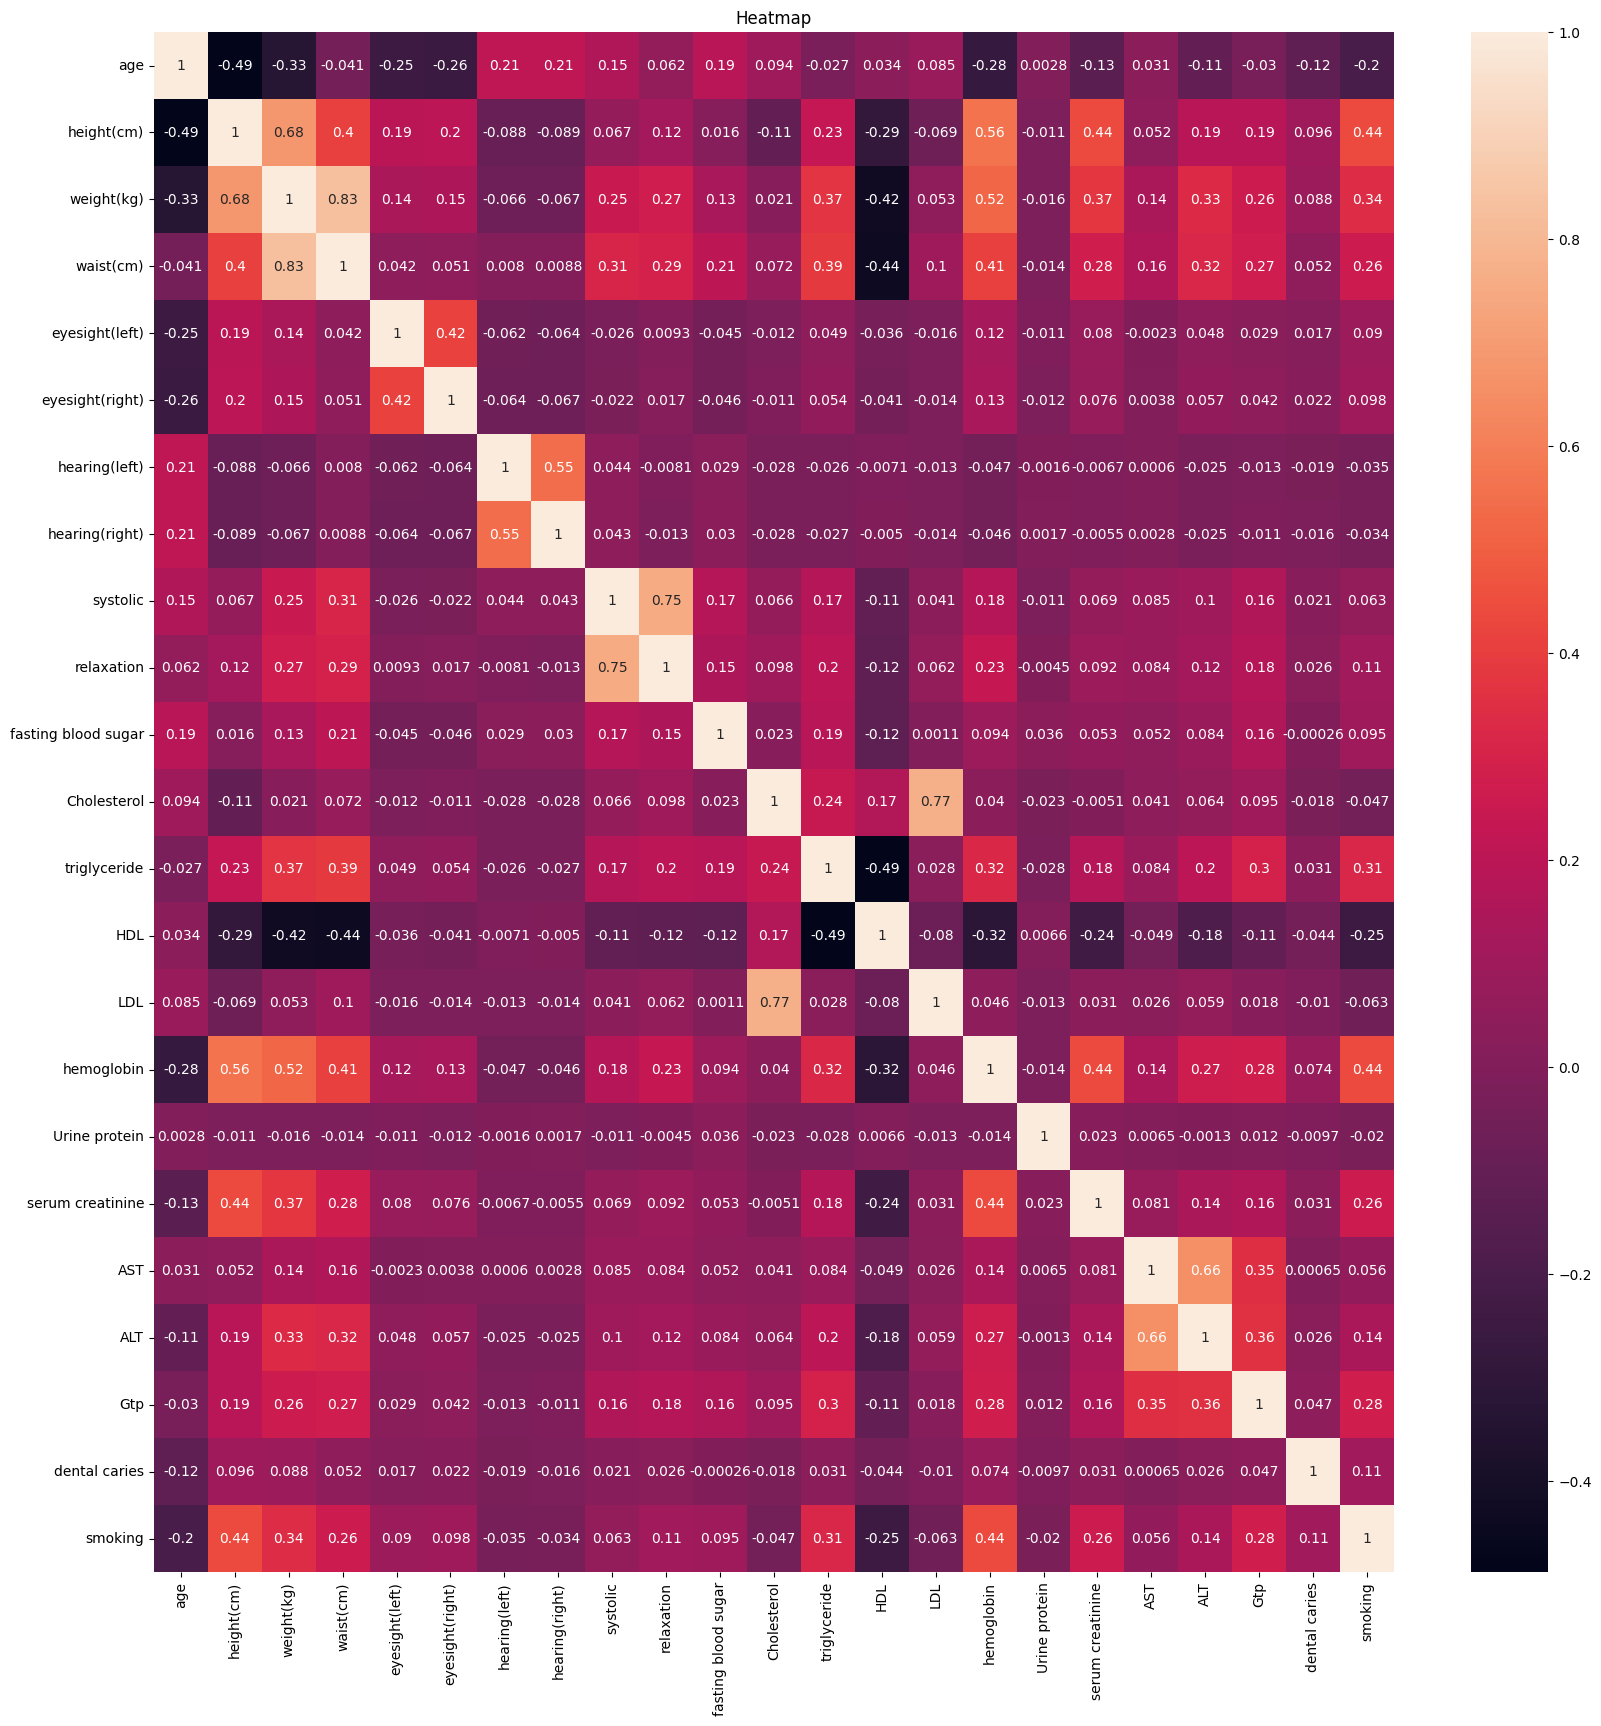

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(20,20))
fig.fontsize = 18
plt.subplots_adjust(hspace=0.2)
sns.heatmap(data = train_df.corr(), annot=True, ax = axes)
axes.set_title("Heatmap")

/tmp/ipykernel_26/2658627039.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,2)


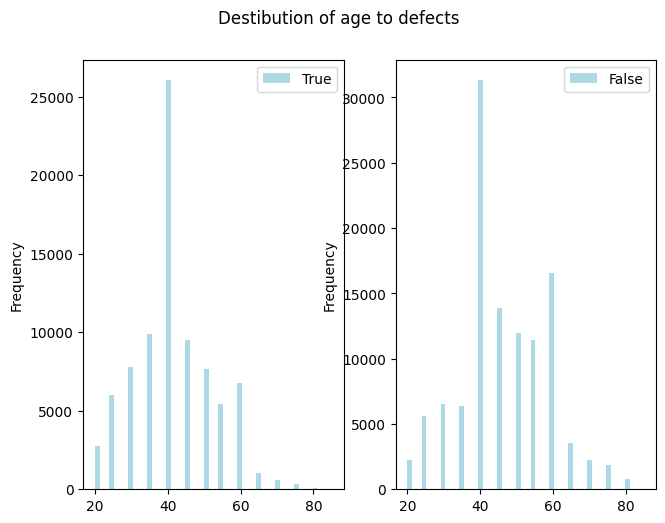

<Figure size 1000x1000 with 0 Axes>

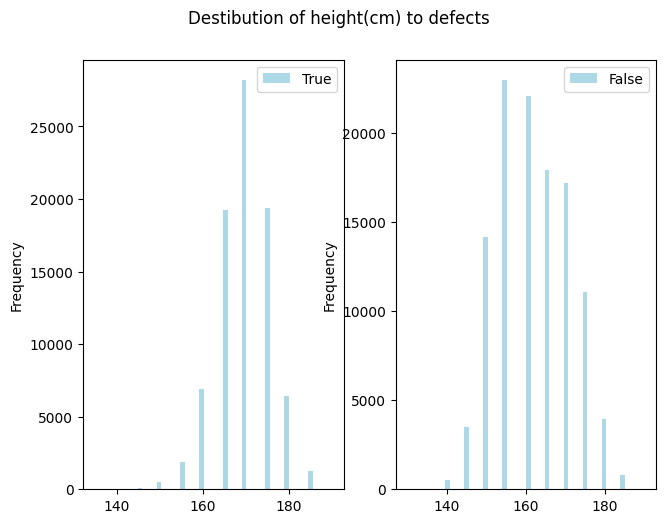

<Figure size 1000x1000 with 0 Axes>

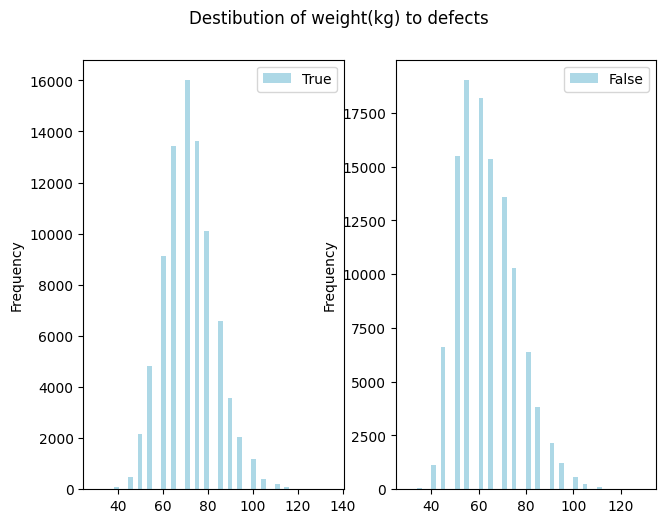

<Figure size 1000x1000 with 0 Axes>

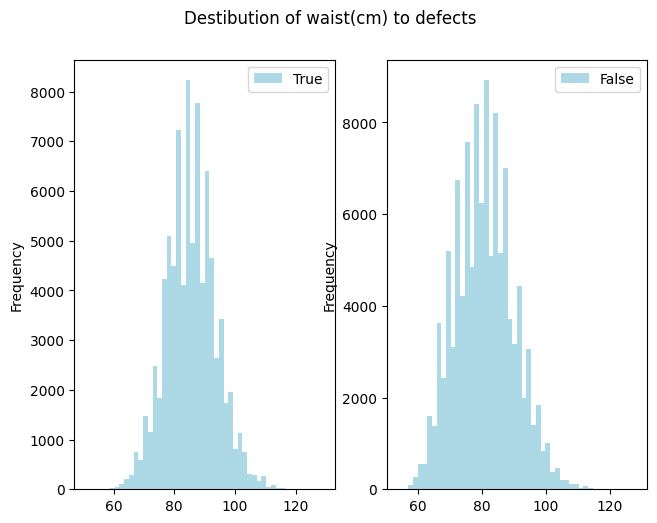

<Figure size 1000x1000 with 0 Axes>

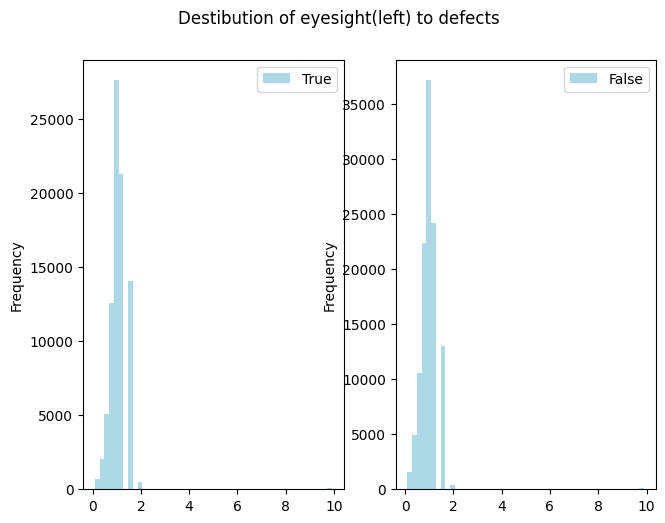

<Figure size 1000x1000 with 0 Axes>

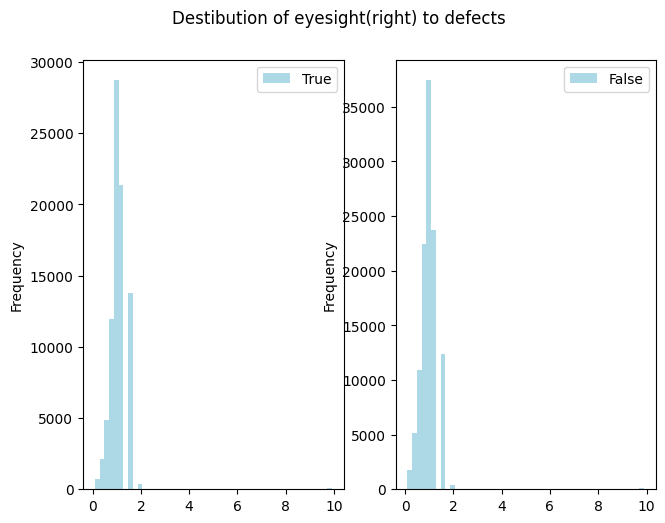

<Figure size 1000x1000 with 0 Axes>

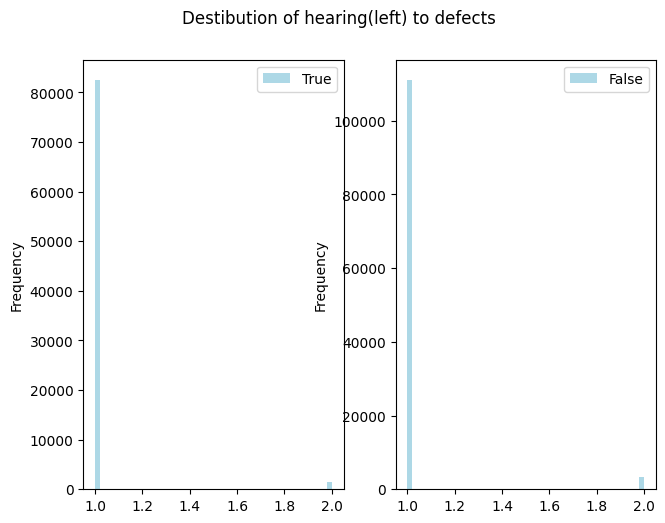

<Figure size 1000x1000 with 0 Axes>

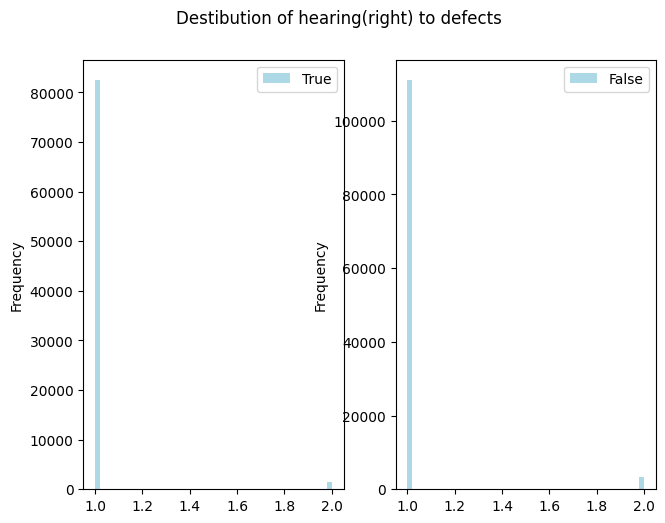

<Figure size 1000x1000 with 0 Axes>

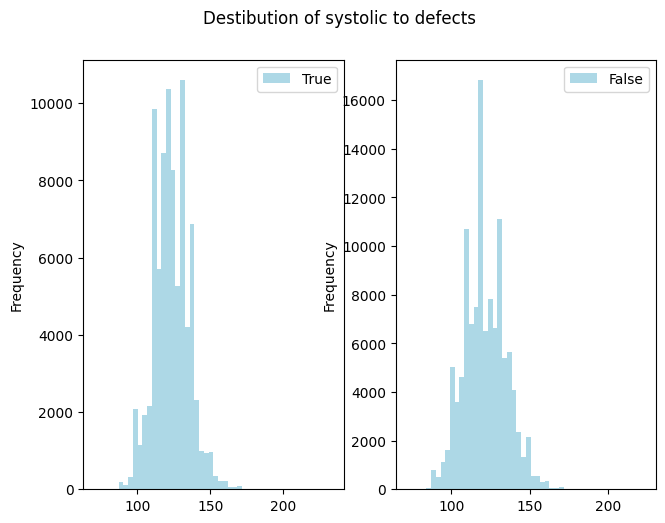

<Figure size 1000x1000 with 0 Axes>

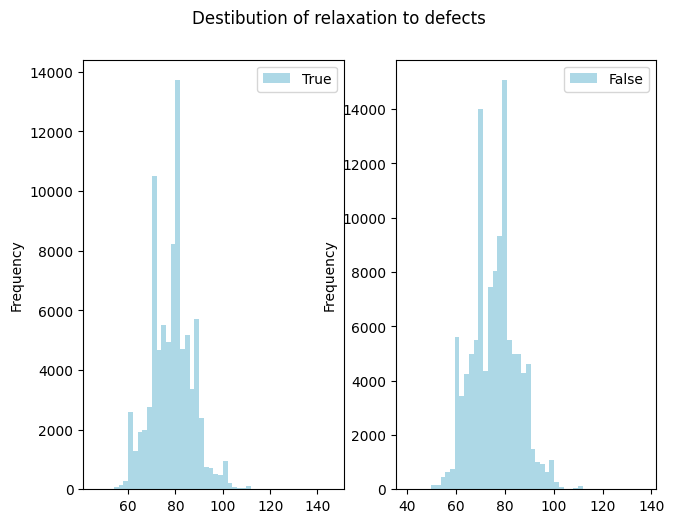

<Figure size 1000x1000 with 0 Axes>

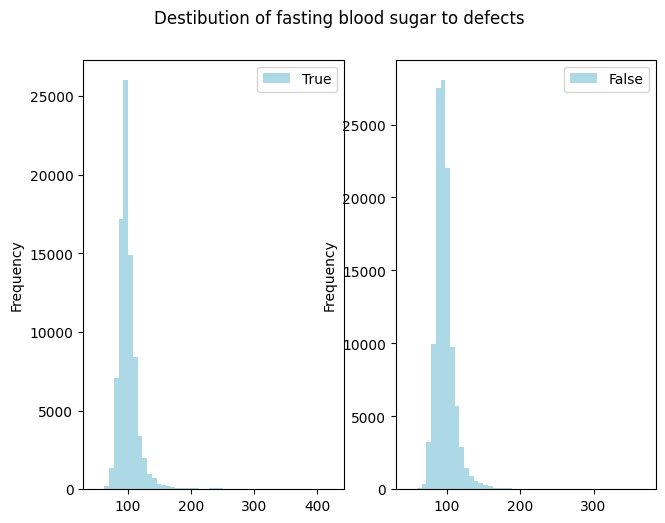

<Figure size 1000x1000 with 0 Axes>

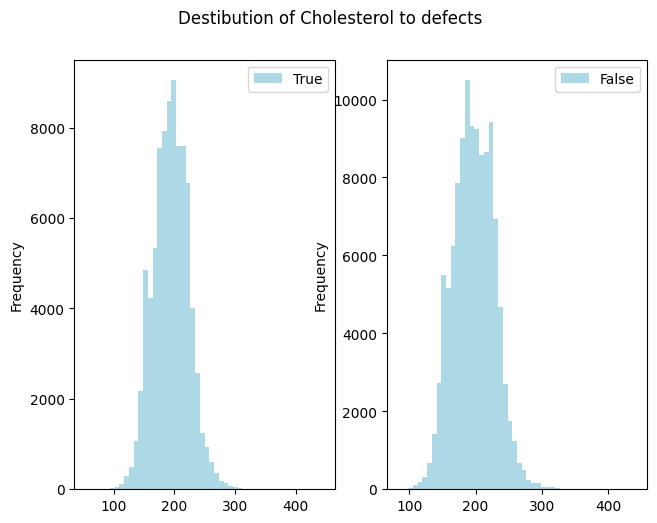

<Figure size 1000x1000 with 0 Axes>

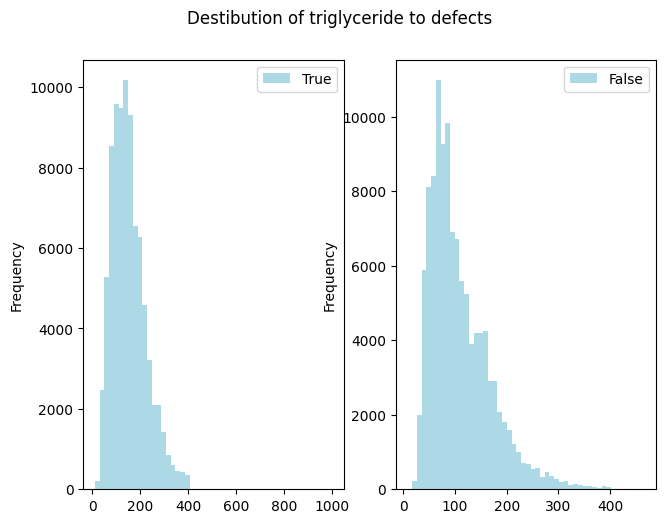

<Figure size 1000x1000 with 0 Axes>

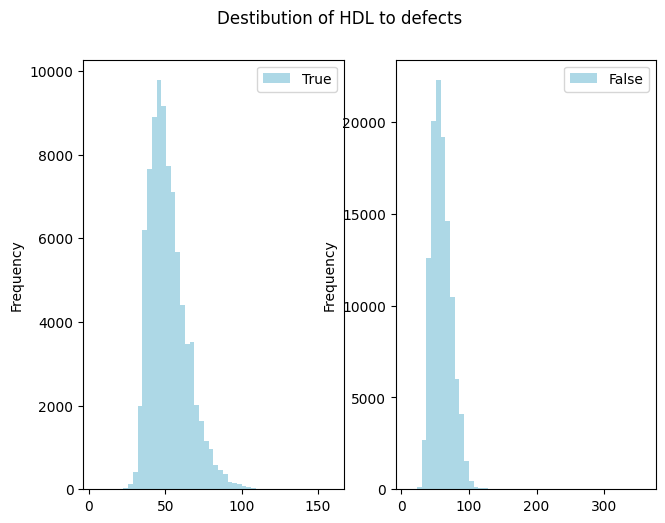

<Figure size 1000x1000 with 0 Axes>

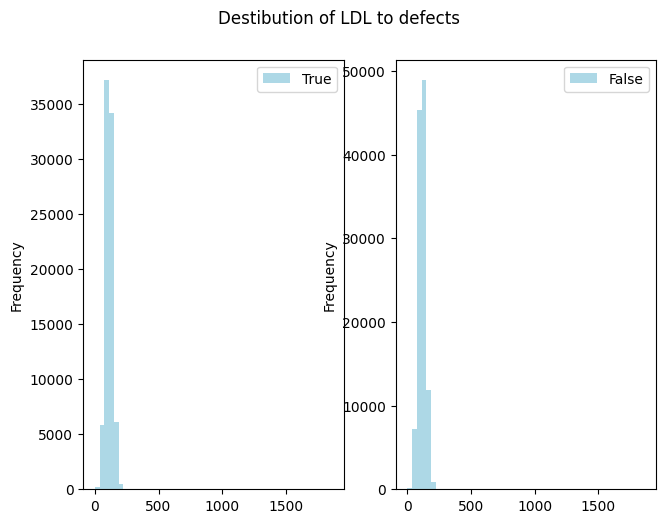

<Figure size 1000x1000 with 0 Axes>

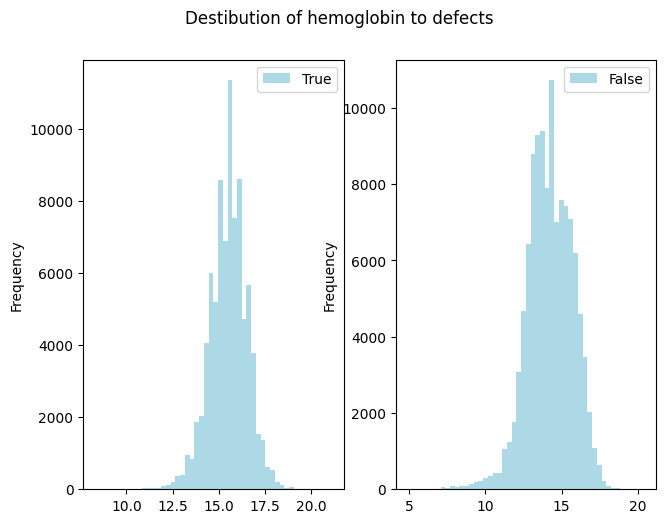

<Figure size 1000x1000 with 0 Axes>

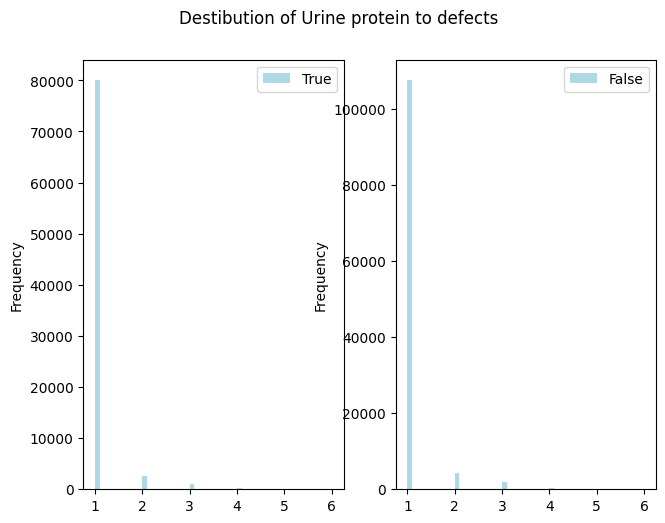

<Figure size 1000x1000 with 0 Axes>

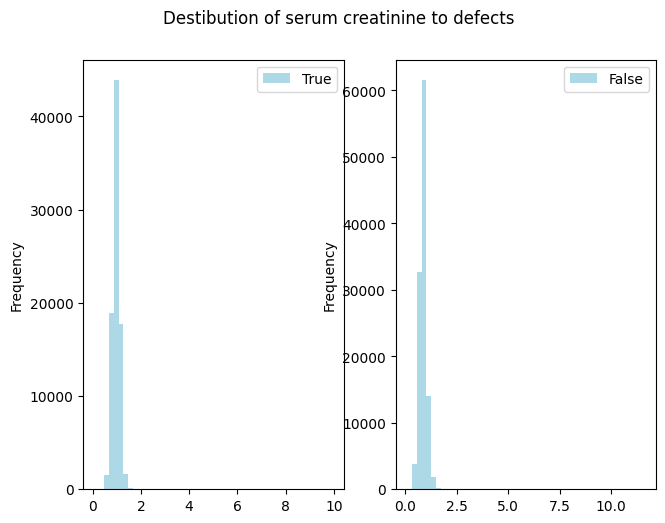

<Figure size 1000x1000 with 0 Axes>

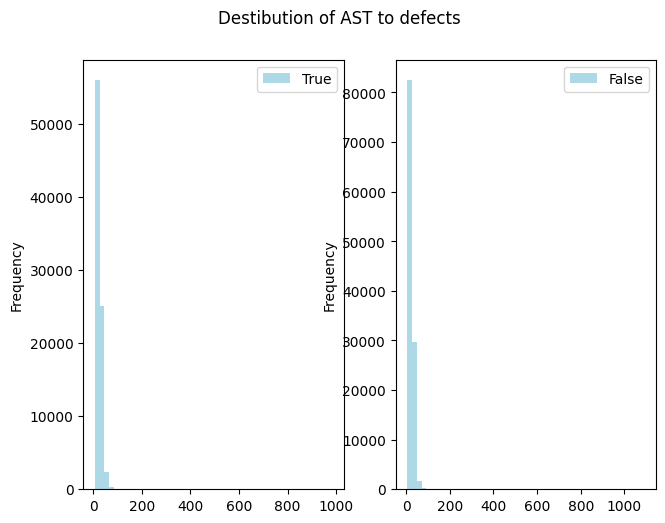

<Figure size 1000x1000 with 0 Axes>

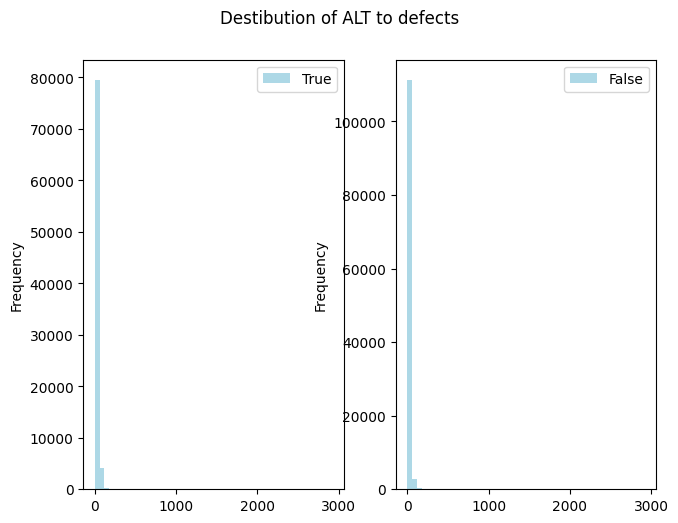

<Figure size 1000x1000 with 0 Axes>

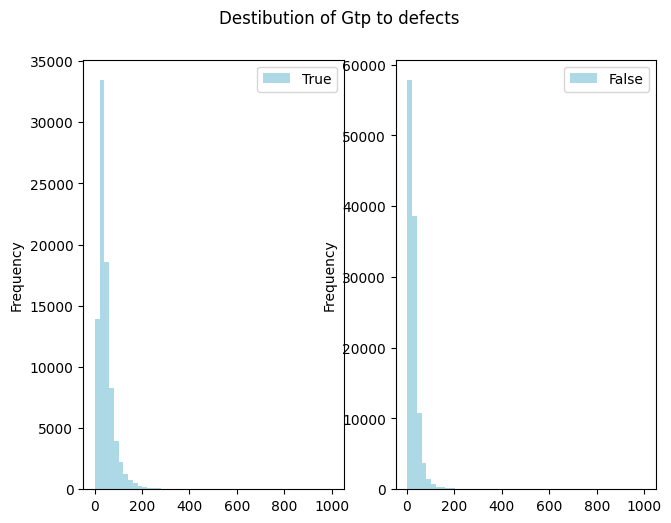

<Figure size 1000x1000 with 0 Axes>

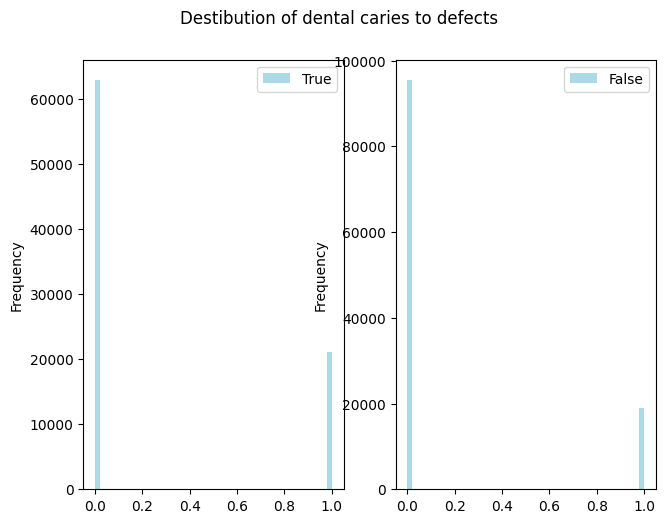

<Figure size 1000x1000 with 0 Axes>

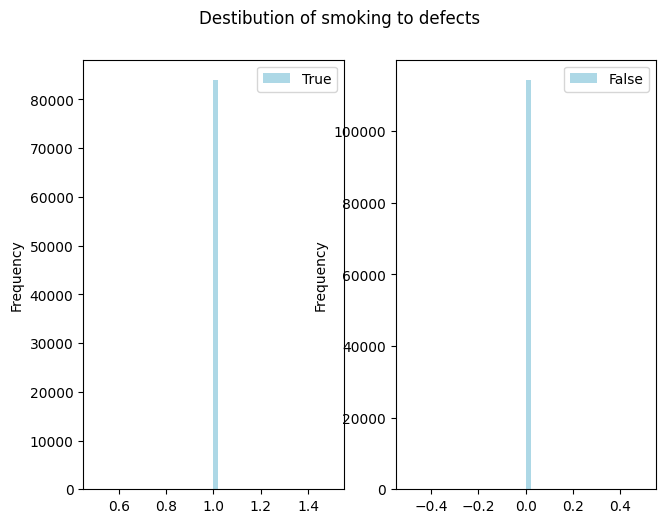

<Figure size 1000x1000 with 0 Axes>

In [8]:
def plot_feature(df):
    
    columns = df.columns
    for column in columns:
        
        fig, axes = plt.subplots(1,2)
        plt.subplots_adjust(left=0.1, right=0.995, bottom=0.1, top=0.995)
        plt.figure(figsize=(10,10))
        
        fig.suptitle(f"Destibution of {column} to defects",x=0.5, y=1.1, fontsize = 12)
        
        df.query("smoking==1")[column].plot(kind="hist", ax=axes[0], bins=50, label="True", color="lightblue")
        axes[0].legend()
        
        df.query("smoking==0")[column].plot(kind="hist", ax=axes[1], bins=50, label="False", color="lightblue")
        axes[1].legend()

        
plot_feature(train_df)

In [9]:
def plot_num(column):
    print("Number of missing values: {}\n".format(train_df[column].isna().sum()))
    print(f"{column}stats:")
    print(train_df[column].describe())
    print()
    
    fig, axes = plt.subplots(1, 3)
    
    fig.suptitle(f"Destibution of {column} to defects", fontsize = 12)
    
    train_df.query("smoking == 1")[column].plot(kind = "hist", ax=axes[0], bins = 50, label = "True", color = "lightblue")
    axes[0].legend()
    
    train_df.query("smoking == 0")[column].plot(kind = "hist", ax=axes[1], bins = 50, label="False", color = "lightblue")
    axes[1].legend()
    
    sns.histplot(data = train_df, x = column, bins = 100,
                 ax = axes[2])
    axes[0].set_title(f'{column} Distribution')
    
    
    fig, axes = plt.subplots(1, 1, figsize = (7,4))

    sns.boxplot(data = train_df, y = column, ax = axes)
    axes.set_title(f'{column} BoxPlot')

Number of missing values: 0

eyesight(right)stats:
count    198240.000000
mean          1.002519
std           0.414241
min           0.100000
25%           0.800000
50%           1.000000
75%           1.200000
max           9.900000
Name: eyesight(right), dtype: float64



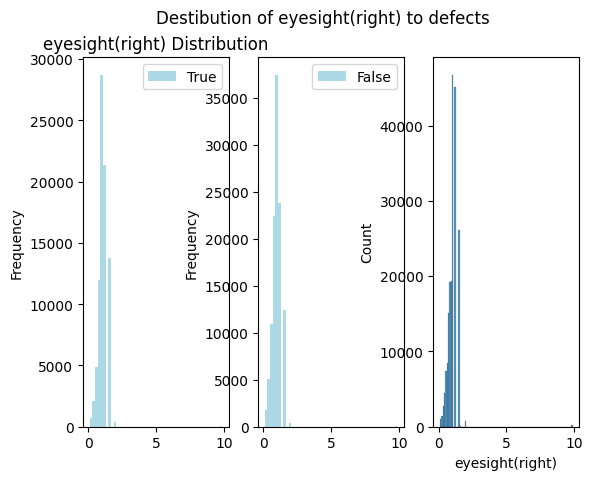

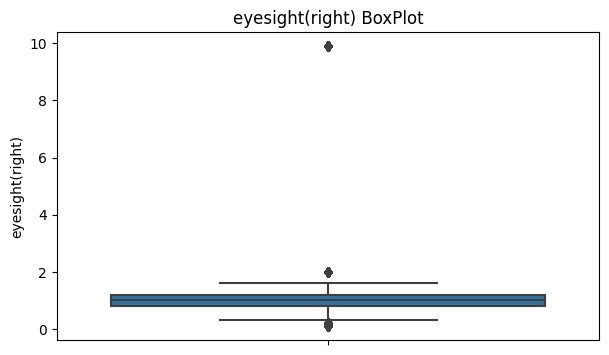

In [10]:
plot_num("eyesight(right)")

In [11]:
# コレステロールとLDL、systokicとrelaxation間で相関が強い。多重共線性


Text(0.5, 1.0, 'Training data')

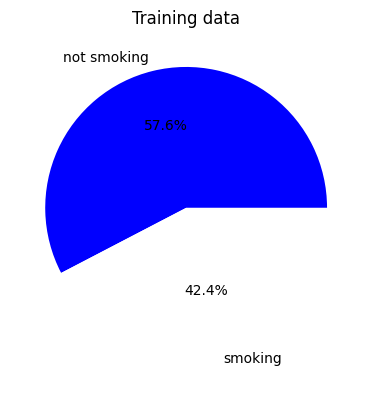

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
class_counts = np.bincount(train_df["smoking"])
plt.pie(class_counts, labels=['not smoking', 'smoking'], colors=['blue','white'], autopct='%1.1f%%');

plt.title("Training data")

In [13]:
# サンプリング必要なし

In [14]:
train_df.corr()["smoking"]

age                   -0.197586
height(cm)             0.437073
weight(kg)             0.342749
waist(cm)              0.256513
eyesight(left)         0.089973
eyesight(right)        0.098198
hearing(left)         -0.035186
hearing(right)        -0.033604
systolic               0.062593
relaxation             0.110132
fasting blood sugar    0.094883
Cholesterol           -0.046617
triglyceride           0.314849
HDL                   -0.254475
LDL                   -0.063120
hemoglobin             0.441413
Urine protein         -0.020131
serum creatinine       0.258388
AST                    0.055705
ALT                    0.137933
Gtp                    0.277741
dental caries          0.105695
smoking                1.000000
Name: smoking, dtype: float64

In [15]:
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=0)
X, Y = train_df.drop("smoking", axis=1), train_df["smoking"]

In [16]:
corrs = []
for c in X.columns:
    corr = np.corrcoef(X[c], Y)[0,1]
    corrs.append(corr)
corrs = np.array(corrs)

idx = np.argsort(np.abs(corrs))[::-1]
top_cols, top_importance = X.columns.values[idx][:17], corrs[idx][:17]
print(top_cols, top_importance)

# X = X[top_cols]
display(X)

['hemoglobin' 'height(cm)' 'weight(kg)' 'triglyceride' 'Gtp'
 'serum creatinine' 'waist(cm)' 'HDL' 'age' 'ALT' 'relaxation'
 'dental caries' 'eyesight(right)' 'fasting blood sugar' 'eyesight(left)'
 'LDL' 'systolic'] [ 0.44141261  0.43707283  0.34274914  0.314849    0.27774105  0.25838829
  0.25651318 -0.25447479 -0.19758572  0.13793332  0.11013199  0.10569547
  0.09819833  0.09488337  0.08997303 -0.06312014  0.06259322]


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,300,40,75,16.5,1,1.0,22,25,27,0
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,55,57,126,16.2,1,1.1,27,23,37,1
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,197,45,93,17.4,1,0.8,27,31,53,0
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,203,38,102,15.9,1,1.0,20,27,30,1
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,87,44,93,15.4,1,0.8,19,13,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198235,40,165,60,80.0,0.4,0.6,1,1,107,60,...,53,61,72,12.3,1,0.5,18,18,21,1
198236,45,155,55,75.0,1.5,1.2,1,1,126,72,...,100,76,131,12.5,2,0.6,23,11,12,0
198237,40,170,105,124.0,0.6,0.5,1,1,141,85,...,196,48,138,17.1,1,0.8,24,23,35,1
198238,40,160,55,75.0,1.5,1.5,1,1,95,69,...,48,79,116,12.0,1,0.6,24,20,17,0


In [17]:

def create_features(df):
    df['BMI'] = df['weight(kg)'] / (df['height(cm)'] ** 2)
    df['HW_Ratio'] = df['height(cm)'] / df['waist(cm)']
    df['HA_Ratio'] = df['height(cm)'] / df['age']
    return df

def count_outliers(df):
    clf = IsolationForest(contamination="auto")
    
    predictions = clf.fit_predict(df)
    
    outlier_count_df = pd.DataFrame({'Outlier_Count': [(pred == -1) for pred in predictions]})
    total_outliers = outlier_count_df['Outlier_Count'].sum()
    
    df['Outlier_Count'] = outlier_count_df
    
    return df

# X = create_features(X)
X = count_outliers(X)

In [18]:
if OPTUNA:
    def xgb_objective(trial):

        params = param = {"lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
                          "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
                          "subsample": trial.suggest_float("subsample", 0.01, 1.0, step = 0.1),
                          "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0, step = 0.1),
                          "max_depth": trial.suggest_int("max_depth", 1, 12),
                          "n_estimators": trial.suggest_int("n_estimators", 256, 4096),
                          "eta": trial.suggest_float("eta", 0.01, 0.5, step = 0.01),
                          "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
                         }

        xgb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skf.split(X,Y)):
            train_X = X.iloc[train_idx]
            val_X = X.iloc[val_idx]
            train_Y = Y.iloc[train_idx]
            val_Y = Y.iloc[val_idx]

            xgb_model = XGBClassifier(**params)

            xgb_model.fit(train_X,train_Y)
            
            xgb_prediction = xgb_model.predict_proba(val_X)[:,1]
            xgb_prediction[xgb_prediction>1]=1
            xgb_prediction[xgb_prediction<0]=0
            xgb_auc_score = roc_auc_score(val_Y, xgb_prediction)
            print(f'The AUC score evaluated on the validation subset using XGB model for fold {idx}: ', xgb_auc_score)

            xgb_auc_score_avg += xgb_auc_score
            
        xgb_auc_score_avg /=n_folds
        print(f'The averaged AUC score evaluated on the validation subset using XGB model:', xgb_auc_score_avg)
        return -xgb_auc_score_avg

    xgb_study = optuna.create_study()
    xgb_study.optimize(xgb_objective, n_trials=10)
    best_xgb_params = xgb_study.best_trial.params

    print('Best XGB hyper parameters:', best_xgb_params)

In [19]:
if OPTUNA:
    def clf_objective(trial):
        params = {"n_estimators":trial.suggest_int("n_estimators",1,21),
                  "max_depth":trial.suggest_int("max_depth",1,5),
                  "max_features":trial.suggest_categorical("nax_feature",["sqrt","log2",None]),
                  "random_state":0}
        
        clf_auc_score_avg = 0
        
        for idx, (train_idx, val_idx) in enumerate(skf.split(X, Y)):
            train_X ,val_X = X.loc[train_idx], X.loc[val_idx]
            train_Y ,val_Y = Y[train_idx], Y[val_idx]
            
            clf_model = RandomForestClassifier(**params)
        
            clf_model.fit(train_X, train_Y)
            clf_prediction = clf_model.predict_proba(val_X)[:,1]
            clf_prediction[clf_prediction>1] = 1
            clf_auc_score = roc_auc_score(val_Y, clf_prediction)
            print(f"auc score of RandomForest is {clf_auc_score}" )
            clf_auc_score_avg += clf_auc_score
            
        return -clf_auc_score_avg/n_folds
    clf_study = optuna.create_study()
    clf_study.optimize(clf_objective, n_trials=10)
    best_clf_params = clf_study.best_trial.params
    
    print("Best CLF hyper parameters:", best_clf_params)

In [20]:
if OPTUNA:
    def cb_objective(trial):
        params = {'iterations':100, #The number of trees to grow.
          'learning_rate':trial.suggest_float('learning_rate',0.01,0.3), #The learning rate controls how quickly the model learns from the data.
          'depth':trial.suggest_int('depth',5,10), #The maximum depth of the trees.
          'subsample':trial.suggest_float('subsample',0.7,0.9), #The proportion of the training data to use for each iteration.
          'colsample_bylevel':0.8, #The proportion of features to use at each level of the tree.
          'min_data_in_leaf':20, #The minimum number of data points in a leaf node.
          'loss_function':'Logloss', #The loss function to optimize.
          }
        
        cb_auc_score_avg = 0
        
        for idx, (train_idx, val_idx) in enumerate(skf.split(X, Y)):
            train_X ,val_X = X.loc[train_idx], X.loc[val_idx]
            train_Y ,val_Y = Y[train_idx], Y[val_idx]
            
            cb_model = CatBoostClassifier(**params)
        
            cb_model.fit(train_X, train_Y,verbose=0)
            cb_prediction = cb_model.predict_proba(val_X)[:,1]
            cb_auc_score = roc_auc_score(val_Y, cb_prediction)
            print(f"auc score of CatBoost is {cb_auc_score}" )
            cb_auc_score_avg += cb_auc_score
            
        return -cb_auc_score_avg/n_folds
    cb_study = optuna.create_study()
    cb_study.optimize(cb_objective, n_trials=10)
    best_cb_params = cb_study.best_trial.params
    
    print("Best CB hyper parameters:", best_cb_params)

In [21]:
if OPTUNA:
    def dp_objective(trial):
        params={"input_dropout":trial.suggest_float("input_dropout",0,0.2,step=0.05),
                "hidden_layers":trial.suggest_int("hidden_layers",2,4,step=1),
                "hidden_units":trial.suggest_int("hidden_units",32,256,step=32),
                "hidden_activation":trial.suggest_categorical("hidden_activation",["relu","prelu"]),
                "hidden_dropout":trial.suggest_float("hidden_dropout",0.0,0.3,step=0.05),
                "optimizer":trial.suggest_categorical("optimizer",["Adam","SGD"]),
                "learning_rate":trial.suggest_uniform("learning_rate",0.01,0.08),
                "batch_norm":trial.suggest_categorical("batch_norm",["before_act","None"]),
                "batch_size":trial.suggest_int("batch_size",32,128,step=32),
                
               }
        
        auc_score_dp_avg = 0
        
        for idx, (train_idx, val_idx) in enumerate(skf.split(X, Y)):
            train_X ,val_X = X.loc[train_idx], X.loc[val_idx]
            train_Y ,val_Y = Y[train_idx], Y[val_idx]
            
            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X)
            val_X = scaler.transform(val_X)
            model = Sequential()
            model.add(Dropout(params["input_dropout"], input_shape=(train_X.shape[1],)))
            
            for i in range(params["hidden_layers"]):
                model.add(Dense(params["hidden_units"]))
                if params["batch_norm"]=="before_act":
                    model.add(BatchNormalization())
                if params["hidden_activation"]=="relu":
                    model.add(ReLU())
                else :
                    model.add(PReLU())
                
                model.add(Dropout(params["hidden_dropout"]))
                
            model.add(Dense(1,activation="sigmoid"))
            
            if params["optimizer"]=="SGD":
                optimizer=SGD(lr=params["learning_rate"])
            if params["optimizer"]=="Adam":
                optimizer=Adam(lr=params["learning_rate"])
            
            model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=["accuracy"])
            
            model.fit(train_X, train_Y)
            dp_prediction = model.predict(val_X)
            auc_score_dp = roc_auc_score(val_Y, dp_prediction,)
            print(f"auc_score of Deep Learning is {auc_score_dp}")
            auc_score_dp_avg += auc_score_dp
            
        auc_score_dp_avg /= n_folds
            
        return -auc_score_dp_avg
        
    dp_study = optuna.create_study()
    dp_study.optimize(dp_objective, n_trials=10)
    best_dp_params = dp_study.best_trial.params
    
    print("Best DP hyper parameters:", best_dp_params)

In [22]:
if OPTUNA:
    def lgb_objective(trial):
        params = {'boosting_type': 'gbdt', 
                  'colsample_bytree': 1.0, 
                  'learning_rate': 0.09273502446736404, 
                  'max_depth': -1, 
                  'min_child_samples': 20, 
                  'min_child_weight': 0.001, 
                  'min_split_gain': 0.0, 
                  'n_jobs': -1, 
                  'num_leaves': 10, 
                  'random_state': None, 
                  'reg_alpha': 0.8978200441138784,
                  'reg_lambda': 0.0020343781703193705, 
                  'subsample': 1.0, 
                  'subsample_for_bin': 200000, 
                  'subsample_freq': 0, 
                  'verbose': -1, 
                  'objective': 'binary', 
                  'metric': ['auc'], 
                  'num_iterations': 100, 
                  'early_stopping_round': None}

        lgb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skf.split(X,Y)):
            train_X = X.iloc[train_idx]
            val_X = X.iloc[val_idx]
            train_Y = Y[train_idx]
            val_Y = Y[val_idx]
            
            lgb_model = LGBMClassifier(**params)

            lgb_model.fit(train_X,train_Y)

            # Select the best model
            bst = lgb_model.booster_

            lgb_prediction = lgb_model.predict_proba(val_X, num_iteration=bst.best_iteration)[:,1]
            lgb_prediction[lgb_prediction>1]=1
            lgb_auc_score = roc_auc_score(val_Y, lgb_prediction)
            print(f'The AUC score evaluated on the validation subset using LGB model for fold {idx}: ', lgb_auc_score)

            lgb_auc_score_avg += lgb_auc_score
            
        lgb_auc_score_avg /=n_folds
        print(f'The averaged AUC score evaluated on the validation subset using LGB model:', lgb_auc_score_avg)
        return -lgb_auc_score_avg

    lgb_study = optuna.create_study()
    lgb_study.optimize(lgb_objective, n_trials=10)
    best_lgb_params = lgb_study.best_trial.params

    print('Best LGBM parameters:', best_lgb_params)

In [23]:
best_clf_params = {"n_estimators":21,
              "max_depth":5,
              "max_features":"sqrt",
              "random_state":0}

best_cb_params = {'iterations':100, 
          'learning_rate': 0.18451176315925508, 
          'depth': 9,
          'subsample': 0.8511264592271087,
          'colsample_bylevel':0.8, 
          'min_data_in_leaf':20, 
          'loss_function':'Logloss', 
          }

best_dp_params = {'input_dropout': 0.05,
                  'hidden_layers': 2,
                  'hidden_units': 32,
                  'hidden_activation': 'relu',
                  'hidden_dropout': 0.05,
                  'optimizer': 'Adam',
                  'learning_rate': 0.05030876007889111,
                  'batch_norm': 'before_act',
                  'batch_size': 64}

best_xgb_params = {'n_estimators'          : 2048,
                   'max_depth'             : 9,
                   'learning_rate'         : 0.045,
                   'booster'               : 'gbtree',
                   'subsample'             : 0.75,
                   'colsample_bytree'      : 0.30,
                   'reg_lambda'            : 1.00,
                   'reg_alpha'             : 0.80,
                   'gamma'                 : 0.80,
                   'random_state'          : 0,
                   'objective'             : 'binary:logistic',
                   'tree_method'           : 'gpu_hist',
                   'eval_metric'           : 'auc',
                   'early_stopping_rounds' : 256,
                   'n_jobs'                : -1,
         }

best_xgb_params2 = [
                  {'n_estimators'          : 2048,
                   'max_depth'             : 9,
                   'learning_rate'         : 0.045,
                   'booster'               : 'gbtree',
                   'subsample'             : 0.75,
                   'colsample_bytree'      : 0.30,
                   'reg_lambda'            : 1.00,
                   'reg_alpha'             : 0.80,
                   'gamma'                 : 0.80,
                   'random_state'          : 0,
                   'objective'             : 'binary:logistic',
                   'tree_method'           : 'gpu_hist',
                   'eval_metric'           : 'auc',
                   'early_stopping_rounds' : 256,
                   'n_jobs'                : -1,
         },
                  {'learning_rate': 0.02176686607620317, 
                   'colsample_bytree': 0.25158338972481126, 
                   'colsample_bylevel': 0.8100944055807549, 
                   'subsample': 0.9208898538931167, 
                   'reg_alpha': 0.0001462866743827207, 
                   'reg_lambda': 1.977118972508752e-08, 
                   'max_depth': 15, 
                   'n_estimators': 2150, 
                   'min_child_weight': 36, 
                   'objective'             : 'binary:logistic',
                   'tree_method'           : 'gpu_hist',
                   'eval_metric'           : 'auc',
                   'early_stopping_rounds' : 256,
                   'n_jobs'                : -1,},

                  {'learning_rate': 0.021235726569277403, 
                   'colsample_bytree': 0.24990983375337267, 
                   'colsample_bylevel': 0.8653919440781894, 
                   'subsample': 0.9839368616173155, 
                   'reg_alpha': 7.442611257681795e-06, 
                   'reg_lambda': 1.801623812712683e-08, 
                   'max_depth': 13, 
                   'n_estimators': 1950, 
                   'min_child_weight': 31,
                   'objective'             : 'binary:logistic',
                   'tree_method'           : 'gpu_hist',
                   'eval_metric'           : 'auc',
                   'early_stopping_rounds' : 256,
                   'n_jobs'                : -1,},
    
                  {'learning_rate': 0.019093223225293453, 
                   'colsample_bytree': 0.21329015151846925, 
                   'colsample_bylevel': 0.9148369225084079, 
                   'subsample': 0.8831564960046078, 
                   'reg_alpha': 1.1496763786731952e-05, 
                   'reg_lambda': 7.512814356733987e-07, 
                   'max_depth': 12, 
                   'n_estimators': 1950, 
                   'min_child_weight': 21,
                   'objective'             : 'binary:logistic',
                   'tree_method'           : 'gpu_hist',
                   'eval_metric'           : 'auc',
                   'early_stopping_rounds' : 256,
                   'n_jobs'                : -1,},]

best_lgb_params = {'boosting_type': 'gbdt', 
                  'colsample_bytree': 1.0, 
                  'learning_rate': 0.09273502446736404, 
                  'max_depth': -1, 
                  'min_child_samples': 20, 
                  'min_child_weight': 0.001, 
                  'min_split_gain': 0.0, 
                  'n_jobs': -1, 
                  'num_leaves': 10, 
                  'random_state': None, 
                  'reg_alpha': 0.8978200441138784,
                  'reg_lambda': 0.0020343781703193705, 
                  'subsample': 1.0, 
                  'subsample_for_bin': 200000, 
                  'subsample_freq': 0, 
                  'verbose': -1, 
                  'objective': 'binary', 
                  'metric': ['auc'], 
                  'num_iterations': 100, 
                  'early_stopping_round': None}

In [24]:
def dp_model_setup(params):
    model = Sequential()
    model.add(Dropout(params["input_dropout"], input_shape=(train_X.shape[1],)))
    for i in range(params["hidden_layers"]):
                model.add(Dense(params["hidden_units"]))
                if params["batch_norm"]=="before_act":
                    model.add(BatchNormalization())
                if params["hidden_activation"]=="relu":
                    model.add(ReLU())
                else :
                    model.add(PReLU())
                
                model.add(Dropout(params["hidden_dropout"]))
                
                model.add(Dense(1,activation="sigmoid"))
            
                if params["optimizer"]=="SGD":
                    optimizer=SGD(lr=params["learning_rate"])
                if params["optimizer"]=="Adam":
                    optimizer=Adam(lr=params["learning_rate"])
            
                model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=["accuracy"])
                
    return model

In [25]:
%%time
def xgb_set_up(x,y,params):
    models = []
    for param in params:
        model = XGBClassifier(**param)
    
        for idx, (train_idx, val_idx) in enumerate(skf.split(x,y)):
            train_X ,val_X = x.iloc[train_idx], x.iloc[val_idx]
            train_Y ,val_Y = y[train_idx], y[val_idx]
        
        
    
            model.fit(train_X, train_Y, eval_set = [(val_X, val_Y)], verbose=0)
        
            best_iteration = model.get_booster().best_ntree_limit
        
            prediction = model.predict_proba(val_X, ntree_limit=best_iteration)[:,1]
            score = roc_auc_score(val_Y, prediction)
            print(f"{idx} time score is {score}")
        models.append(model)
    return models

xgb_models = xgb_set_up(X, Y, best_xgb_params2)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0 time score is 0.8790702805428197


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1 time score is 0.8815148406890705


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 time score is 0.8822490632059383


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


3 time score is 0.8770402473748501


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 time score is 0.8769062331755979


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 time score is 0.8767654187379905


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 time score is 0.8784196796334238


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 time score is 0.8765716979248872


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 time score is 0.8749389476684818


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 time score is 0.8787639801306311


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0 time score is 0.87696495673184


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1 time score is 0.880142552588953


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 time score is 0.8819752559075599


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


3 time score is 0.8767412765891012


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 time score is 0.876227762191423


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 time score is 0.8772270116222795


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 time score is 0.8780245519140565


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 time score is 0.8756454585626876


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 time score is 0.8746225255430762


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 time score is 0.8783882005223855


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0 time score is 0.8771281468790111


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1 time score is 0.8794485478802282


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 time score is 0.8820192099386155


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


3 time score is 0.8757030078595435


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 time score is 0.875792401031181


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 time score is 0.877382552093291


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 time score is 0.8778351509458548


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 time score is 0.8754122494689275


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 time score is 0.8743651743004268


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 time score is 0.8778274492199627


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0 time score is 0.8760593446873962


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1 time score is 0.8786946489648698


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 time score is 0.8808166568300307


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


3 time score is 0.8750319467902662


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 time score is 0.8751495153556104


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 time score is 0.8765282493521613


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 time score is 0.876814698319697


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 time score is 0.8751124449374799


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 time score is 0.8735795200957673


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 time score is 0.877028814636956
CPU times: user 17min, sys: 4.97 s, total: 17min 5s
Wall time: 14min 38s


In [26]:
if False:
    cb_models, dp_models, xgb_models, lgb_models = [], [], [], []
    cb_predictions, dp_predictions, xgb_predictions, lgb_predictions = [], [], [], []
    val_Y_all = []
    for idx, (train_idx, val_idx) in enumerate(skf.split(X,Y)):
        train_X ,val_X = X.iloc[train_idx], X.iloc[val_idx]
        train_Y ,val_Y = Y[train_idx], Y[val_idx]
    
        val_Y_all.append(val_Y)
        print(len(val_X))
        print(len(val_Y))
    
        cb_model = CatBoostClassifier(**best_cb_params, verbose=0)
        cb_model.fit(train_X, train_Y)
        cb_prediction = cb_model.predict_proba(val_X)[:,1]
        print(len(cb_prediction))
        cb_predictions.append(cb_prediction)
        cb_models.append(cb_model)
    
        xgb_model = XGBClassifier(**best_xgb_params)
        xgb_model.fit(train_X, train_Y)
        xgb_prediction = xgb_model.predict_proba(val_X)[:,1]
        xgb_predictions.append(xgb_prediction)
        xgb_models.append(xgb_model)
    
        lgb_model = LGBMClassifier(**best_lgb_params)
        lgb_model.fit(train_X, train_Y)
        lgb_prediction = lgb_model.predict_proba(val_X)[:,1]
        lgb_predictions.append(lgb_prediction)
        lgb_models.append(lgb_model)
    
        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        val_X_std = scaler.transform(val_X)
        dp_model = dp_model_setup(best_dp_params)
        dp_model.fit(train_X, train_Y)
        dp_prediction = dp_model.predict(val_X_std)
        dp_prediction = dp_prediction.reshape(len(val_X))
        dp_predictions.append(dp_prediction)
        dp_models.append(dp_model)
    
    
        print(f"{idx} times study done")

In [27]:
if False:
    for lgb_prediction, xgb_prediction, cb_prediction, dp_prediction, val_Y in zip(lgb_predictions, xgb_predictions, cb_predictions, dp_predictions, val_Y_all):
        xgb_prediction[xgb_prediction>=0.5]=1
        xgb_prediction[xgb_prediction<0.5]=0
        cb_prediction[cb_prediction>=0.5]=1
        cb_prediction[cb_prediction<0.5]=0
        dp_prediction[dp_prediction>=0.5]=1
        dp_prediction[dp_prediction<0.5]=0
        lgb_prediction[lgb_prediction>=0.5]=1
        lgb_prediction[lgb_prediction<0.5]=0
    
        cm_lgb = confusion_matrix(val_Y, lgb_prediction)
        cm_xgb = confusion_matrix(val_Y, xgb_prediction)
        cm_cb = confusion_matrix(val_Y, cb_prediction)
        cm_dp = confusion_matrix(val_Y, dp_prediction)
    
    
        fig, axes = plt.subplots(2,2)
        plt.subplots_adjust(left=0.1, right=0.995, bottom=0.1, top=0.995)
    
        sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt=',', ax=axes[0,0])
        axes[0,0].set_xlabel("prediction")
        axes[0,0].set_ylabel("True")
        axes[0,0].set_title("XGBoost")
    
    
        sns.heatmap(cm_cb, annot=True, cmap='Blues', fmt=',', ax=axes[0,1])
        axes[0,1].set_xlabel("prediction")
        axes[0,1].set_ylabel("True")
        axes[0,1].set_title("CatCoost")
    
    
        sns.heatmap(cm_dp, annot=True, cmap='Blues', fmt=',', ax=axes[1,0])
        axes[1,0].set_xlabel("prediction")
        axes[1,0].set_ylabel("True")
        axes[1,0].set_title("DeepLearning")
    
    
        sns.heatmap(cm_lgb, annot=True, cmap='Blues', fmt=',', ax=axes[1,1])
        axes[1,1].set_xlabel("prediction")
        axes[1,1].set_ylabel("True")
        axes[1,1].set_title("lightgbm")

In [28]:
if False:
    for xgb_prediction, cb_prediction, dp_prediction, val_Y in zip(xgb_predictions, cb_predictions, dp_predictions, val_Y_all):
        tpr_xgb, fpr_xgb, _ = roc_curve(val_Y, xgb_prediction)
        tpr_cb, fpr_cb, _ = roc_curve(val_Y, cb_prediction)
        tpr_dp, fpr_dp, _ = roc_curve(val_Y, dp_prediction)
    
        plt.subplot(3,1,1)
        plt.plot(fpr_xgb, tpr_xgb)
        plt.xlabel("fpr")
        plt.ylabel("tpr")
        plt.title("xgboost")
    
        plt.subplot(3,1,2)
        plt.plot(fpr_cb, tpr_cb)
        plt.xlabel("fpr")
        plt.ylabel("tpr")
        plt.title("CatBoost")
    
        plt.subplot(3,1,3)
        plt.plot(fpr_dp, tpr_dp)
        plt.xlabel("fpr")
        plt.ylabel("tpr")
        plt.title("DeepLearning")

In [29]:
if True:
    ensemble_predictions = []
    def ensemble_objective(trial):
    
        weights = {'cb_weight':trial.suggest_int('cb_weight',0,10),
                   'dp_weight':trial.suggest_int('dp_weight',0,10),
                   "xgb_weight":trial.suggest_int("xgb_weight",0,10),
                   "lgb_weight":trial.suggest_int("lgb_weight",0,10)}
    
        sum_weights = weights['cb_weight'] + weights["dp_weight"] + weights["xgb_weight"] + weights["lgb_weight"]
        ensemble_auc_score = 0
    
        for idx, (train_idx,val_idx) in enumerate(skf.split(X,Y)):
            train_X = X.iloc[train_idx]
            val_X = X.iloc[val_idx]
            train_Y = Y[train_idx]
            val_Y = Y[val_idx]

            # CatBoost
            cb_model = cb_models[idx]
            cb_prediction = cb_model.predict_proba(val_X)[:,1]
            cb_auc_score = roc_auc_score(val_Y, cb_prediction)
            print(f'The AUC score evaluated on the validation subset using CatBoost model for fold {idx}: ', cb_auc_score)
            
            # XGBClassifier
            xgb_model = xgb_models[idx]
            xgb_prediction = xgb_model.predict_proba(val_X)[:,1]
            xgb_auc_score = roc_auc_score(val_Y, xgb_prediction)
            print(f'The AUC score evaluated on the validation subset using XGBoost model for fold {idx}: ', xgb_auc_score)
            
            
            # LGBMClassifier
            lgb_model = lgb_models[idx]
            lgb_prediction = lgb_model.predict_proba(val_X)[:,1]
            lgb_auc_score = roc_auc_score(val_Y, lgb_prediction)
            print(f'The AUC score evaluated on the validation subset using lightgbm model for fold {idx}: ', lgb_auc_score)

            
            # DeepLearning
            dp_model = dp_models[idx]
            val_X_std = scaler.transform(val_X)
            dp_prediction = dp_model.predict(val_X_std)
            dp_prediction = dp_prediction.reshape(len(val_X))
            dp_auc_score = roc_auc_score(val_Y, dp_prediction)
            print(f'The AUC score evaluated on the validation subset using DeepLearning model for fold {idx}: ', dp_auc_score)

            # Ensemble
            ensemble_prediction = (weights['cb_weight']*cb_prediction + weights["dp_weight"]*dp_prediction + weights["xgb_weight"]*xgb_prediction + weights["lgb_weight"]*lgb_prediction)/sum_weights
            ensemble_auc_score += roc_auc_score(val_Y, ensemble_prediction)
            
        ensemble_predictions.append(ensemble_auc_score)
        return -ensemble_auc_score/n_folds

    # ensemble_study = optuna.create_study()
    # ensemble_study.optimize(ensemble_objective, n_trials=20)

    # best_ensemble_weights = ensemble_study.best_trial.params

    # print('Best ensemble weights:', best_ensemble_weights)

In [30]:
scaler = StandardScaler()
# test_id, test_X = test_df["id"], test_df[top_cols]
test_id, test_X = test_df["id"], test_df.drop("id", axis=1)
# test_X = create_features(test_X)
test_X = count_outliers(test_X)
test_X_std = scaler.fit_transform(test_X)

In [31]:
def Pseudo_data_structure(df, cutoff = 0.85):
    
    
    Ps_prediction = 0
    
    for xgb_model in xgb_models:
        Ps_prediction += xgb_model.predict_proba(df)[:,1]
    Ps_prediction /= len(xgb_models)
    
    df["prediction"] = Ps_prediction
    pseudo_set_1 = df[df["prediction"] > cutoff]
    pseudo_set_1["smoking"] = 1
    pseudo_set_1.drop(columns=['prediction'], axis = 1, inplace=True)
    
    pseudo_set_2 = df[df["prediction"] < 1 - cutoff]
    pseudo_set_2["smoking"] = 0
    pseudo_set_2.drop(columns=['prediction'], axis = 1, inplace=True)
    
    peseudo_set = pd.concat([pseudo_set_1, pseudo_set_2])
    df_2 = df.iloc[(df["prediction"] <= cutoff) % (df["prediction"] >= 1 - cutoff)]
    df_2 = df_2.drop("prediction", axis=1)
    df = df.drop(columns=["prediction"], axis=1)
    
    
    return peseudo_set, df, df_2

peseudo_set, test_X, test_X_2 = Pseudo_data_structure(test_X)

/tmp/ipykernel_26/4078517012.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pseudo_set_1["smoking"] = 1
/tmp/ipykernel_26/4078517012.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pseudo_set_1.drop(columns=['prediction'], axis = 1, inplace=True)
/tmp/ipykernel_26/4078517012.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [32]:
if True:
    ps_smoking = peseudo_set["smoking"]
    peseudo_X = pd.concat([X, peseudo_set.drop("smoking", axis=1)])
    peseudo_Y = pd.concat([Y, ps_smoking])
    peseudo_set.drop("smoking", axis=1)
    peseudo_X = peseudo_X.reset_index(drop=True)
    peseudo_Y = peseudo_Y.reset_index(drop=True)

In [33]:
if False:    
    def ps_objective(trial):
    
        Ps_prediction = 0
   
        Ps_prediction += xgb_model.predict_proba(test_X)[:,1]
    
        test_X["prediction"] = Ps_prediction
        pseudo_set_1 = test_X[test_X["prediction"] > cutoff]
        pseudo_set_1["smoking"] = 1
        pseudo_set_1.drop(columns=['prediction'], axis = 1, inplace=True)
    
        pseudo_set_2 = test_X[test_X["prediction"] < 1 - cutoff]
        pseudo_set_2["smoking"] = 0
        pseudo_set_2.drop(columns=['prediction'], axis = 1, inplace=True)
    
        peseudo_set = pd.concat([pseudo_set_1, pseudo_set_2])
        
        test_X = test_X.drop(columns=["prediction"], axis=1)
        
        ps_smoking = peseudo_set["smoking"]
        peseudo_X = pd.concat([X, peseudo_set.drop("smoking", axis=1)])
        peseudo_Y = pd.concat([Y, ps_smoking])
        peseudo_set.drop("smoking", axis=1)
        peseudo_X = peseudo_X.reset_index(drop=True)
        peseudo_Y = peseudo_Y.reset_index(drop=True)
        
        prediction_avg, xgb_model, score_sum = peseudo_predict(test_X, best_xgb_params, peseudo_X, peseudo_Y)
    
        
        return -score_sum

    ps_study = optuna.create_study()
    ps_study.optimize(ps_objective, n_trials=10)
    best_cut_off = lgb_study.best_trial.params

In [34]:
def peseudo_predict(df, params, ps_X, ps_Y):
    score_sum = 0
    peseudo_prediction = 0 
    for param in params:
        xgb_model = XGBClassifier(**param)
        for idx, (train_idx,val_idx) in enumerate(skf.split(ps_X,ps_Y)):
                train_X = ps_X.iloc[train_idx]
                val_X = ps_X.iloc[val_idx]
                train_Y = ps_Y[train_idx]
                val_Y = ps_Y[val_idx]
                xgb_model.fit(train_X, train_Y, eval_set=[(val_X, val_Y)], verbose=0)
                best_iteration = xgb_model.get_booster().best_ntree_limit
                prediction_Y = xgb_model.predict_proba(val_X, ntree_limit=best_iteration)[:,1]
                score = roc_auc_score(val_Y, prediction_Y)
                score_sum += score
                print(f"{idx} time score is {score}")
                peseudo_prediction += xgb_model.predict_proba(df)[:,1]
                print(f"{idx} time done")
    score_sum /= n_folds
    peseudo_prediction /= n_folds*len(params)
    print(f"score is {score_sum}")
    
    prediction_avg = peseudo_prediction
    return prediction_avg, xgb_model

prediction_avg, xgb_model = peseudo_predict(test_X, best_xgb_params2, peseudo_X, peseudo_Y)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0 time score is 0.9183639118078242
0 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1 time score is 0.9121418666803439
1 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 time score is 0.9135726633721442
2 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


3 time score is 0.9131192615637737
3 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 time score is 0.9145750995861608
4 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 time score is 0.9176540482712232
5 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 time score is 0.9140762229076766
6 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 time score is 0.9134236458067904
7 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 time score is 0.9170773311659068
8 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 time score is 0.911616112306699
9 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0 time score is 0.9180144789318255
0 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1 time score is 0.9115457379077079
1 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 time score is 0.9131203929491918
2 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


3 time score is 0.9128261896400941
3 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 time score is 0.9146408923419969
4 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 time score is 0.9173386898506576
5 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 time score is 0.9141257773594201
6 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 time score is 0.9129328570224757
7 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 time score is 0.9170048816666561
8 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 time score is 0.9107291451231666
9 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0 time score is 0.9171044284185197
0 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1 time score is 0.9115881666567356
1 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 time score is 0.9128986378155484
2 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


3 time score is 0.912691741543729
3 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 time score is 0.9143730341504915
4 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 time score is 0.9172859529233759
5 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 time score is 0.9135851683195474
6 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 time score is 0.9125968917763962
7 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 time score is 0.9167922960859094
8 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 time score is 0.9106234194308944
9 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0 time score is 0.9167398385696184
0 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1 time score is 0.9109753221135098
1 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 time score is 0.9120415145896101
2 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


3 time score is 0.9123209452376774
3 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 time score is 0.913695416894156
4 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 time score is 0.9163409839051982
5 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 time score is 0.9129555545130936
6 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 time score is 0.9117707232327837
7 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 time score is 0.9162004910761398
8 time done


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 time score is 0.9098221844220455
9 time done
score is 3.656030191793672


In [35]:
# 上から全部0.9005359
# 16 0.8965783105957709

In [36]:
def peseudo_2nd():
    peseudo_set_2, test_X_2, test_X_3 = Pseudo_data_structure(test_X_2)
    ps_smoking = peseudo_set_2["smoking"]
    peseudo_X = pd.concat([peseudo_X, peseudo_set_2.drop("smoking", axis=1)])
    peseudo_Y = pd.concat([Y, ps_smoking])
    peseudo_set_2.drop("smoking", axis=1)
    peseudo_X = peseudo_X.reset_index(drop=True)
    peseudo_Y = peseudo_Y.reset_index(drop=True)
    peseudo_set_2
    
    
# peseudo_2nd()

In [37]:
if False:
    peseudo_X_list = []
    peseudo_Y_list = []
    for idx in range(2,5):
    
        cutoff = 0.95-(0.1*idx)
        print(cutoff)
    peseudo_set_2, test_X_2, test_X_3 = Pseudo_data_structure(test_X_2, cutoff = cutoff)
    if True:
        print(len(peseudo_set_2))
        ps_smoking = peseudo_set_2["smoking"]
        peseudo_X_2 = pd.concat([peseudo_X, peseudo_set_2.drop("smoking", axis=1)])
        peseudo_Y_2 = pd.concat([peseudo_Y, ps_smoking])
        peseudo_set_2.drop("smoking", axis=1)
        peseudo_X_2 = peseudo_X_2.reset_index(drop=True)
        peseudo_X_list.append(peseudo_X_2)
        peseudo_Y_2 = peseudo_Y_2.reset_index(drop=True)
        peseudo_Y_list.append(peseudo_Y_2)

In [38]:
if False:
    for peseudo_X_2, peseudo_Y_2 in zip(peseudo_X_list, peseudo_Y_list):
        prediction_avg = peseudo_predict(test_X, best_xgb_params, peseudo_X_2, peseudo_Y_2)

['height(cm)' 'hemoglobin' 'serum creatinine' 'weight(kg)' 'Gtp'
 'triglyceride' 'age' 'dental caries' 'waist(cm)' 'HDL' 'LDL' 'ALT'
 'relaxation' 'Cholesterol' 'eyesight(left)']


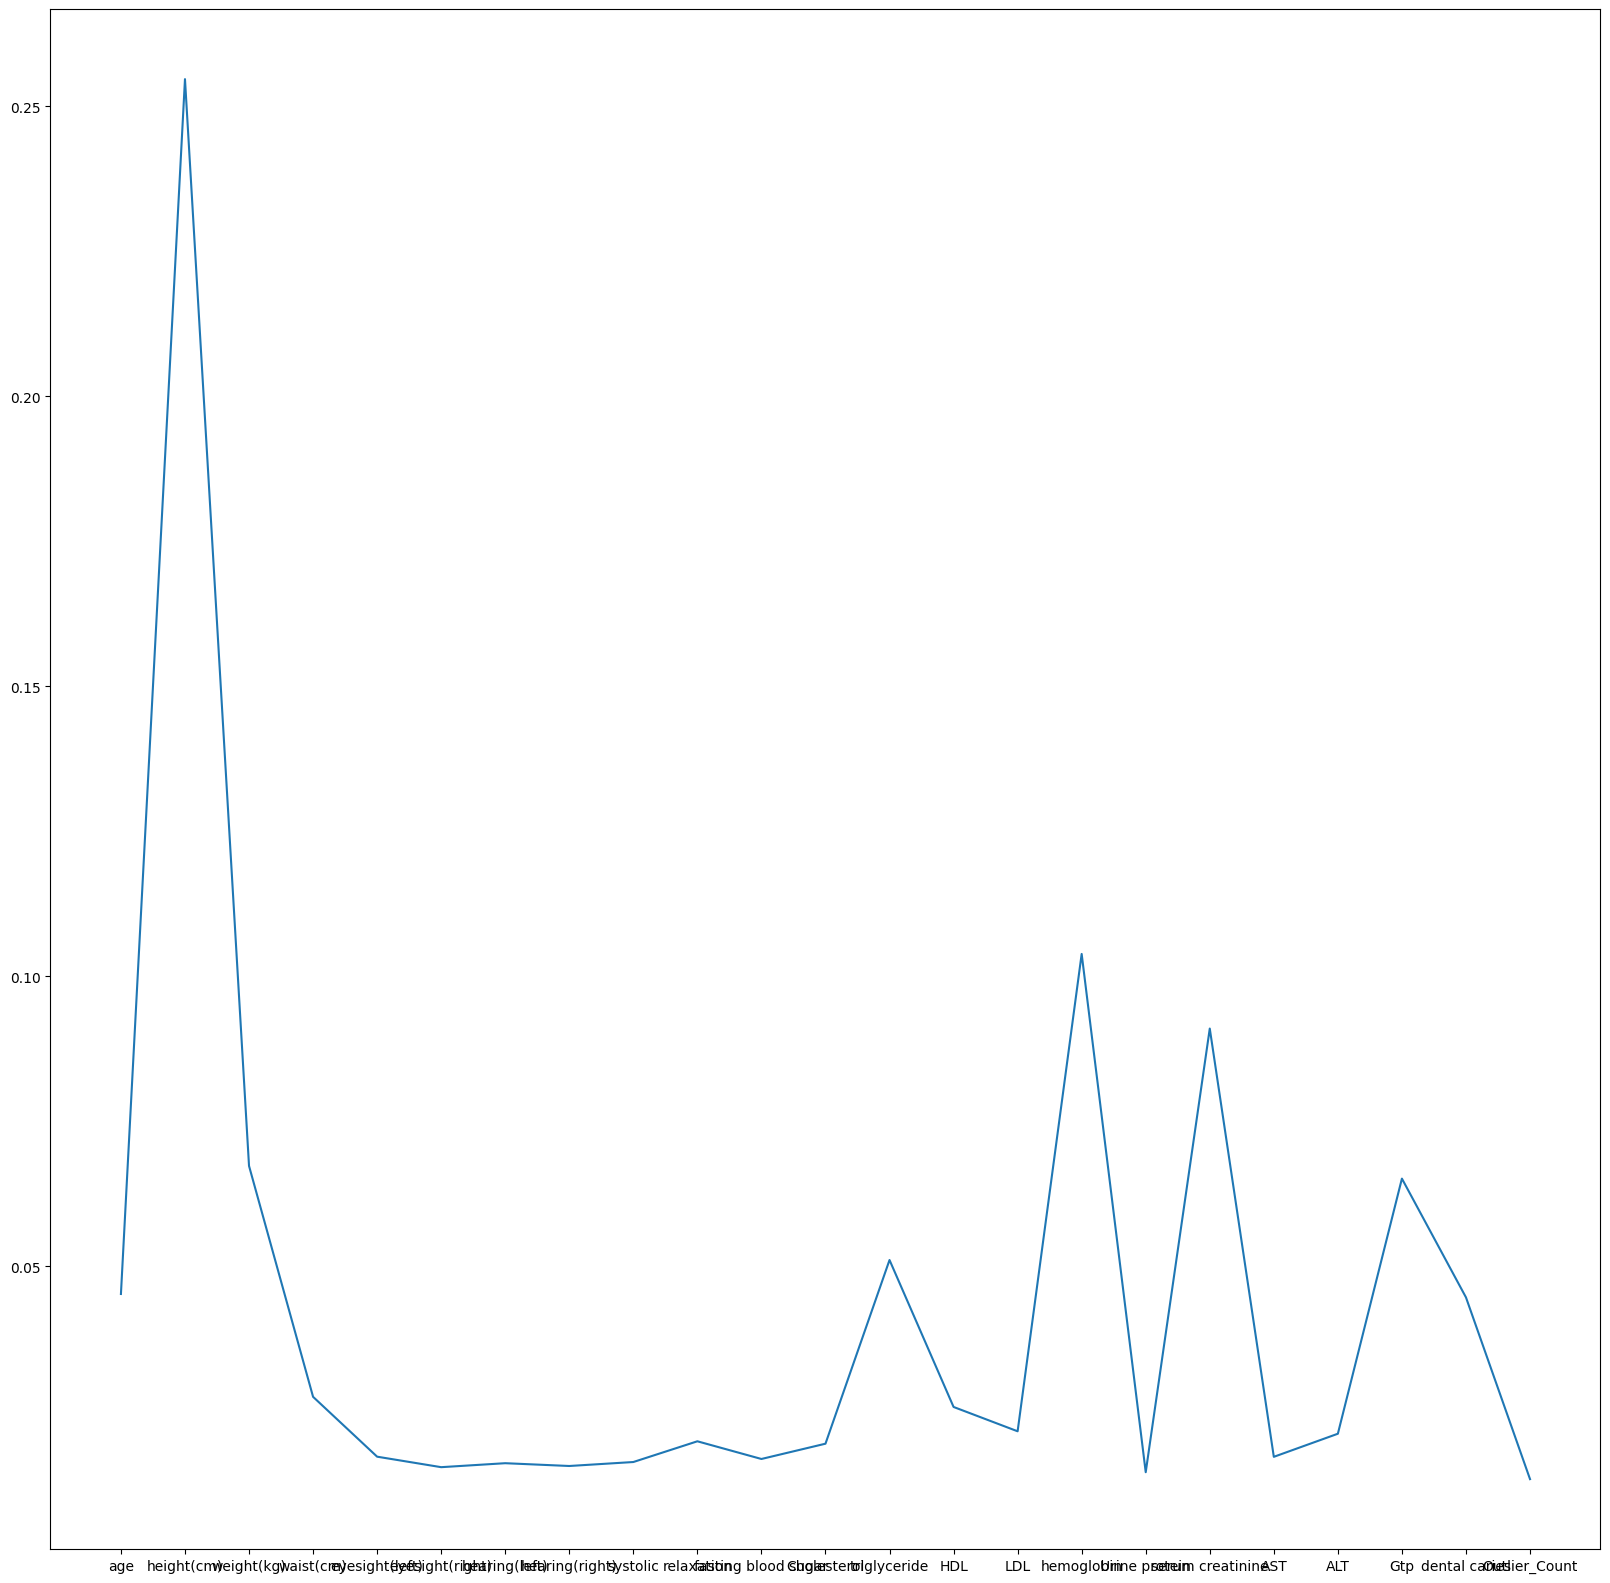

In [39]:
importance = xgb_model.feature_importances_
column = np.array(X.columns)
idx = np.argsort(importance)
importance_column = column[idx][:-16:-1]

plt.figure(figsize=[20,20])
plt.plot(column,importance)
print(importance_column)

Text(0.5, 1.0, 'Training data')

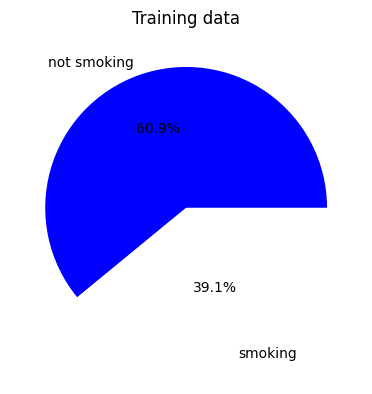

In [40]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
class_counts = np.bincount(peseudo_Y)
plt.pie(class_counts, labels=['not smoking', 'smoking'], colors=['blue','white'], autopct='%1.1f%%');

plt.title("Training data")

In [41]:
def ensemble_predict():
    best_cb_weight = best_ensemble_weights["cb_weight"]
    best_dp_weight = best_ensemble_weights["dp_weight"]
    best_xgb_weight = best_ensemble_weights["xgb_weight"]
    best_lgb_weight = best_ensemble_weights["lgb_weight"]
    sum_weights = best_cb_weight + best_dp_weight + best_xgb_weight + best_lgb_weight
    prediction_avg = 0
    for cb_model, dp_model, xgb_model, lgb_model in zip(cb_models, dp_models, xgb_models, lgb_models):
        cb_prediction = cb_model.predict_proba(test_X)[:,1]
        xgb_prediction = xgb_model.predict_proba(test_X)[:,1]
        lgb_prediction = lgb_model.predict_proba(test_X)[:,1]
        dp_prediction = dp_model.predict(test_X_std)
        dp_prediction = dp_prediction.reshape(106171)
        print(cb_prediction)
        print(dp_prediction)
        prediction_avg += best_cb_weight*cb_prediction/sum_weights
        prediction_avg += best_dp_weight*dp_prediction/sum_weights
        prediction_avg += best_xgb_weight*xgb_prediction/sum_weights
        prediction_avg += best_lgb_weight*lgb_prediction/sum_weights
    prediction_avg /= n_folds
    
    return prediction_avg

# prediction_avg = ensemble_predict()

In [42]:
submission = pd.DataFrame({"id":test_id, "smoking":prediction_avg})
submission

,id,smoking
0,159256,0.647674
1,159257,0.180358
2,159258,0.346387
3,159259,0.011424
4,159260,0.690022
...,...,...
106166,265422,0.677384
106167,265423,0.563586
106168,265424,0.492658
106169,265425,0.066662


In [43]:
submission.to_csv("submission.csv", index=False)